<a href="https://colab.research.google.com/github/f-ssemwanga/vehicle-classification/blob/main/ColabTrained_vehicle_cnn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Vehicle Type Classification with Tensorflow 2.0

1. Build a neural network that classifies vehicle types
2. Train the neural network
3. Evaluate the accuracy of the model

In [1]:
from google.colab import drive

In [3]:
#Import the required modules
# import required libraries
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys


# check the version of tensorflow, make sure it version 2.0 and above
print(tf.__version__)

2.15.0


In [4]:
PROJECT_PATH="/content/drive/MyDrive/Colab Notebooks"
print(f'Project Path: {PROJECT_PATH}')
HDF5_DATASET_PATH = f"{PROJECT_PATH}{os.sep}h5-dataset/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5"
print(f"Dataset Path: {HDF5_DATASET_PATH}")

Project Path: /content/drive/MyDrive/Colab Notebooks
Dataset Path: /content/drive/MyDrive/Colab Notebooks/h5-dataset/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5


#### Loading the training Data

In [5]:
def load_dataset_from_hdf5_file(hdf_file_path):
    hf = h5py.File(hdf_file_path, "r")
    trainX = np.array(hf["trainX"]).astype("f8")
    ascii_train_labels = np.array(hf["trainLabels"]).astype("S40")
    trainY = np.array(hf["trainY"]).astype("int") # binary labels

    devX = np.array(hf["devX"]).astype("f8")
    ascii_dev_labels = np.array(hf["devLabels"]).astype("S40")
    devY = np.array(hf["devY"]).astype("int")

    testX = np.array(hf["testX"]).astype("f8")
    ascii_test_labels = np.array(hf["testLabels"]).astype("S40")
    testY = np.array(hf["testY"]).astype("int")

    trainLabels = np.array([n.decode("unicode_escape") for n in ascii_train_labels])
    devLabels = np.array([n.decode("unicode_escape") for n in ascii_dev_labels])
    testLabels = np.array([n.decode("unicode_escape") for n in ascii_test_labels])

    print(f"trainX.shape: {trainX.shape}")
    print(f"trainY.shape:{trainY.shape}")
    print(f"trainLabels.shape:{trainLabels.shape}")
    print(f"devX.shape:{devX.shape}")
    print(f"devY.shape:{devY.shape}")
    print(f"devLabels.shape:{devLabels.shape}")
    print(f"testX.shape: {testX.shape}")
    print(f"testY.shape: {testY.shape}")
    print(f"testLabels.shape:{testLabels.shape}")

    return trainX, trainY, trainLabels, devX, devY, devLabels, testX, testY, testLabels


In [6]:
IMAGE_SIZE = 224
import datetime

t0 = datetime.datetime.now()
trainX, trainY, trainLabels, devX, devY, devLabels, testX, testY, testLabels = (
    load_dataset_from_hdf5_file(HDF5_DATASET_PATH)
)
t1 = datetime.datetime.now()
print(f"Time to load the data:{t1 - t0}")

trainX.shape: (1089, 224, 224, 3)
trainY.shape:(1089, 8)
trainLabels.shape:(1089,)
devX.shape:(136, 224, 224, 3)
devY.shape:(136, 8)
devLabels.shape:(136,)
testX.shape: (137, 224, 224, 3)
testY.shape: (137, 8)
testLabels.shape:(137,)
Time to load the data:0:00:15.410748


#### Visualise the dataset

In [7]:
LIB_PATH = PROJECT_PATH
sys.path.append(LIB_PATH)
from utils_lib import *

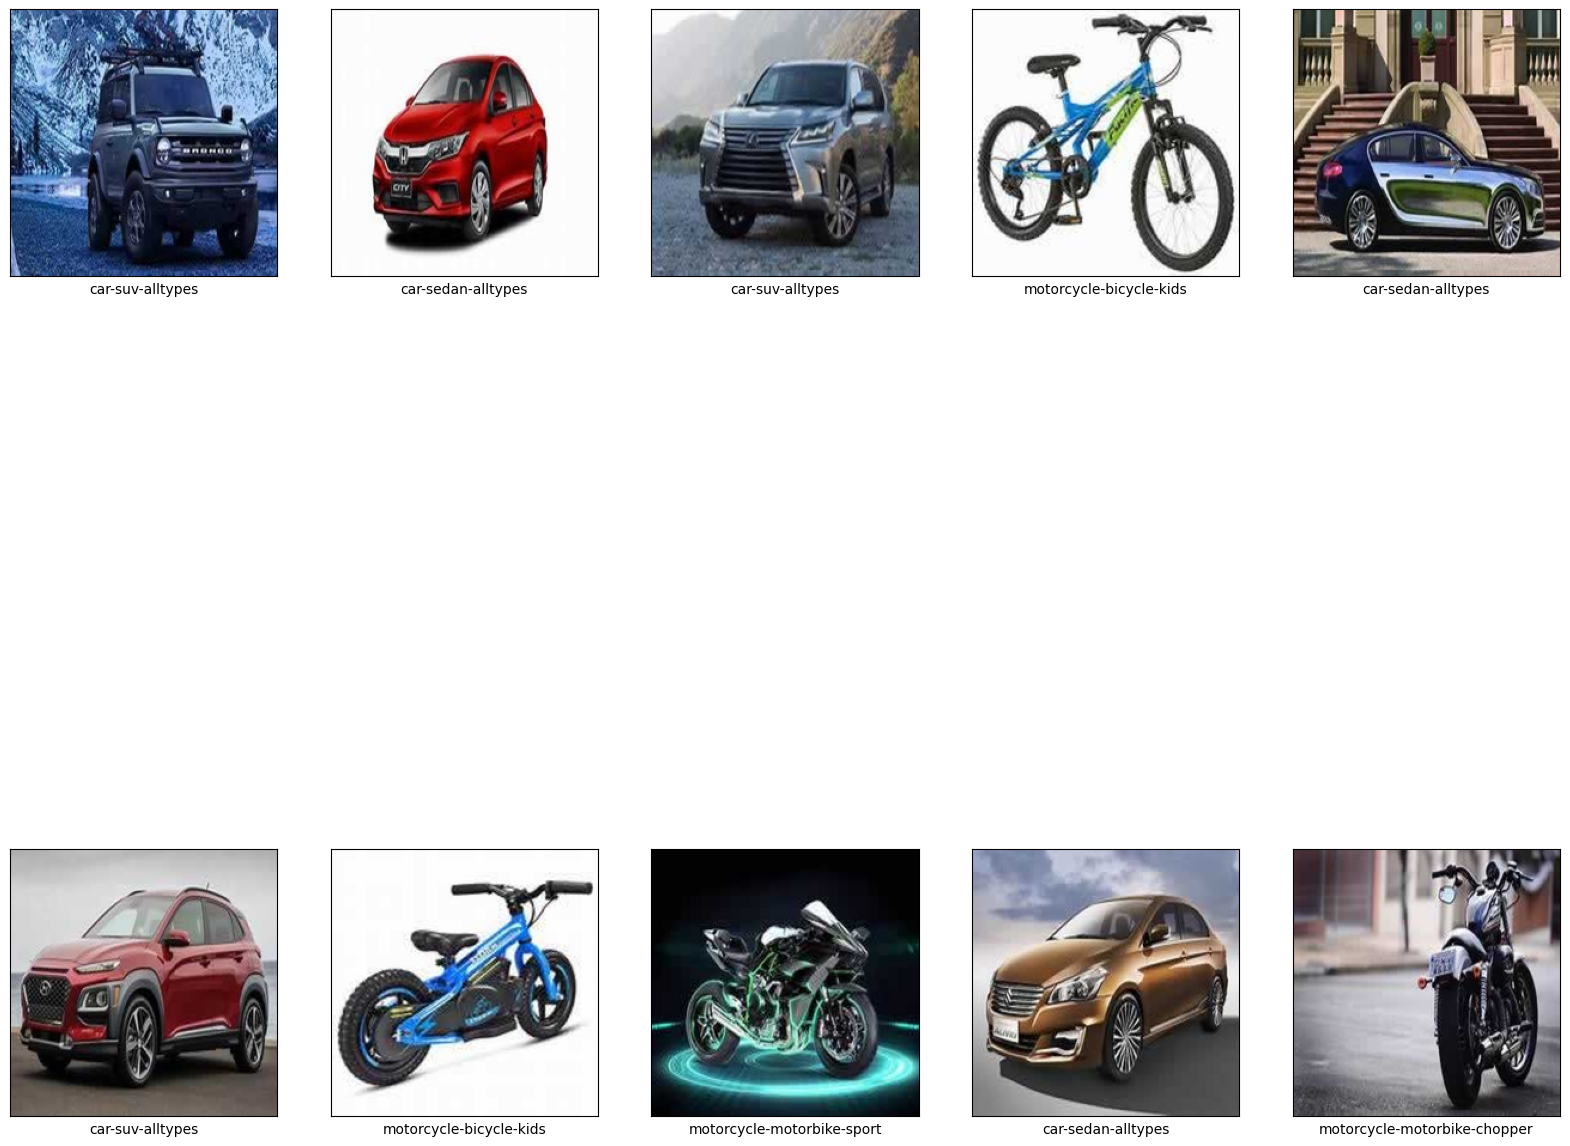

In [8]:
plot_sample_from_dataset(trainX, trainLabels, rows=2, columns=5, width=20, height=20)

#### Building the CNN

Now that we have our dataset prepared, we are ready to create neural networks.

We will create two types of networks. One fully connected neural networks, and one convolutional neural network.

In [10]:
# import keras and its libraries
from tensorflow.keras import datasets, layers, models


def create_cnn_model():
    model = tf.keras.models.Sequential()
    model.add(
        layers.Conv2D(
            32,
            kernel_size=(5, 5),
            activation="relu",
            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        )
    )
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    # model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
    # model.add(layers.MaxPooling2D(pool_size=(2,2)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
    # model.add(layers.MaxPooling2D(pool_size=(2,2)))
    # model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(8, activation="softmax")) #output layers should have the same ast the number of classes

    return model

#### Training the Model

* We will use the Stochastic Gradient Descent Optimiser
* Categorical_crossentropy loss function because we have a sofmax activation function in the last layer
* Metric will be the accuracy

In [11]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
print('creating model')
model = create_cnn_model()
opt=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

creating model


In [13]:
BATCH_SIZE = 64
EPOCHS = 200

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 110, 110, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                        

In [14]:
print("training model")
t0 = datetime.datetime.now()
history = model.fit(
    trainX,
    trainY,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(testX, testY),
)
t1 = datetime.datetime.now()
print(f"time to load data{t1 - t0}")

training model
Epoch 1/200
18/18 [==============================] - 12s 210ms/step - loss: 2.6602 - accuracy: 0.1671 - val_loss: 2.1690 - val_accuracy: 0.1168
Epoch 2/200
18/18 [==============================] - 3s 154ms/step - loss: 2.1490 - accuracy: 0.2773 - val_loss: 2.0703 - val_accuracy: 0.1022
Epoch 3/200
18/18 [==============================] - 3s 168ms/step - loss: 1.8467 - accuracy: 0.3691 - val_loss: 2.0488 - val_accuracy: 0.0949
Epoch 4/200
18/18 [==============================] - 3s 154ms/step - loss: 1.5986 - accuracy: 0.4463 - val_loss: 2.0370 - val_accuracy: 0.0730
Epoch 5/200
18/18 [==============================] - 3s 153ms/step - loss: 1.4520 - accuracy: 0.4968 - val_loss: 2.0156 - val_accuracy: 0.0657
Epoch 6/200
18/18 [==============================] - 3s 152ms/step - loss: 1.3734 - accuracy: 0.5455 - val_loss: 1.9801 - val_accuracy: 0.1022
Epoch 7/200
18/18 [==============================] - 3s 158ms/step - loss: 1.2904 - accuracy: 0.5813 - val_loss: 1.9638 - val_

#### Save the model

In [17]:
model.save(PROJECT_PATH + "model_cnn.h5")
PROJECT_PATH

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Colab Notebooks'

In [18]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [19]:
def plot_history(history):

    # summarize history for accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()
    # summarize history for loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

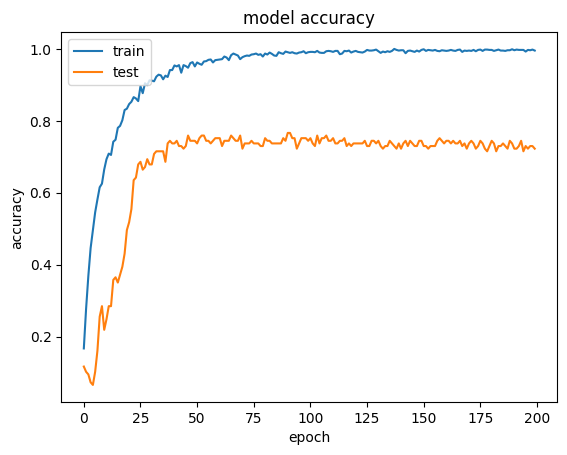

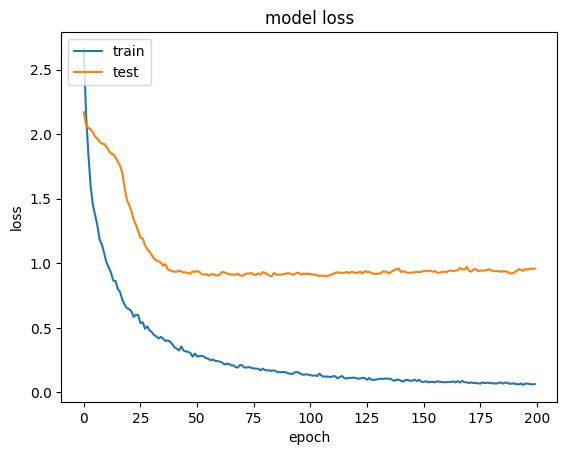

In [20]:
plot_history(history)